In [19]:
%matplotlib notebook 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from tqdm import tqdm
import matplotlib.animation as anim
from mpl_toolkits.mplot3d import Axes3D

class Particle():
    
    #init
    def __init__(self, r0, v0, a0, t, m, R, Id):
        
        self.dt  = t[1] - t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros((len(t),len(r0)))
        self.vVector = np.zeros((len(t),len(r0)))
        self.aVector = np.zeros((len(t),len(r0)))
        
        self.m = m
        self.radius = R
        self.Id = Id
        
    #Methods
    def Evolution(self, i):
        
        self.SetPosition(i, self.r)
        self.SetVelocity(i, self.v)
        
        self.r += self.dt*self.v
        self.v += self.dt*self.a
    
    def CheckWallLimits(self,limits,dim=2):
        
        for i in range(dim):
            
            if self.r[i] + self.radius > limits[i] and self.v[i] < 0:
                self.v[i] = - 0.9*self.v[i]
            if self.r[i] - self.radius < - limits[i] and self.v[i] < 0:
                self.v[i] = - 0.9*self.v[i]
                
    def CheckWallLimits2(self,limits,dim=3):
        
        for i in range(dim):
            
            if self.r[i] + self.radius > limits[i]:
                self.v[i] = -self.v[i]
            if self.r[i] - self.radius < - limits[i]:
                self.v[i] = -self.v[i]
    
    #Setters
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v
    
    #Getters
    def GetPositionVector(self):
        return self.rVector
    
    def GetRPositionVector(self):
        return self.RrVector 
    
    def GetVelocityVector(self):
        return self.vVector
    
    def GetRVelocityVector(self):
        return self.RvVector
    
    def GetR(self):
        return self.radius
    
    def GetMass(self):
        return self.m
    
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        self.RvVector = np.array([self.vVector[0]])
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
    
    
#Discretization
dt = 0.01
tmax = 30
t = np.arange(0,tmax+dt,dt)


def GetParticles(NParticles,Limit,Velo,Dim=3):
    
    Particles_ = []
    
    for i in range(NParticles):
        
        x0 = np.random.uniform( -Limit+1.0, Limit-1.0, size=Dim )
        v0 = np.random.uniform( -Velo, Velo, size=Dim)
        a0 = np.zeros(Dim)
        
        p = Particle(x0,v0,a0,t,1.,1.0,i)
        
        Particles_.append(p)
        
    return Particles_

In [20]:
Limits = np.array([20.,20.])
Limits_2 = [20,20,20]

In [21]:
def RunSimulationGas(t,NParticles = 100, Velo = 6):
    
    Particles = GetParticles(NParticles,Limits_2[0],Velo = Velo)
    
    for it in tqdm(range(len(t))): # Evolucion temporal
        for i in range(len(Particles)):
            
            Particles[i].CheckWallLimits2(Limits_2)
            Particles[i].Evolution(it)
        
        
    return Particles

In [22]:
def RunSimulationParticle(r0, v0, a0, t, m, R, Limits, Id = 1):
    
    Ptcl = Particle(r0, v0, a0, t, m, R, Id)
    
    for i in range(len(t)):
        Ptcl.CheckWallLimits(Limits)
        Ptcl.Evolution(i)
    
    return Ptcl

Ptcl = RunSimulationParticle(np.array([-15.,5.]), np.array([1.,0.]), np.array([0.,-9.8]), t, 1, 1, Limits, Id = 1)


def ReduceTime(t,factor):
    
    Ptcl.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

redt = ReduceTime(t,10)


<IPython.core.display.Javascript object>


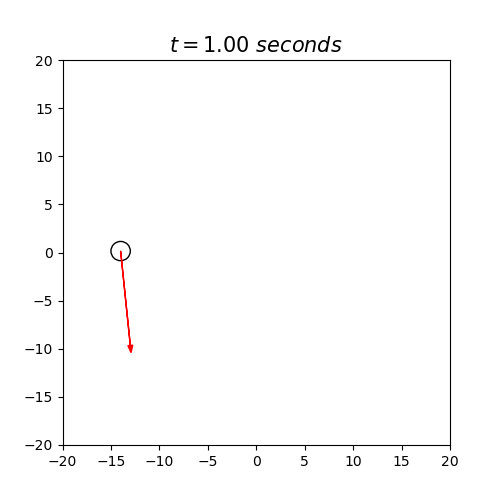

In [23]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)


def init():
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)
    
    
    x = Ptcl.GetRPositionVector()[i,0]
    y = Ptcl.GetRPositionVector()[i,1]
    

        
    vx = Ptcl.GetRVelocityVector()[i,0]
    vy = Ptcl.GetRVelocityVector()[i,1]

        
    circle = plt.Circle( (x,y), Ptcl.GetR(), color='k', fill=False)
    plot = ax.add_patch(circle)
    plot = ax.arrow(x,y,vx,vy,color='r',head_width=0.5)
        
    return plot
#Revisar len Velocity Vector
Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=100, metadata=dict(artist='Me'))
Animation.save('FallingBall.mp4', writer=writer_)


<IPython.core.display.Javascript object>


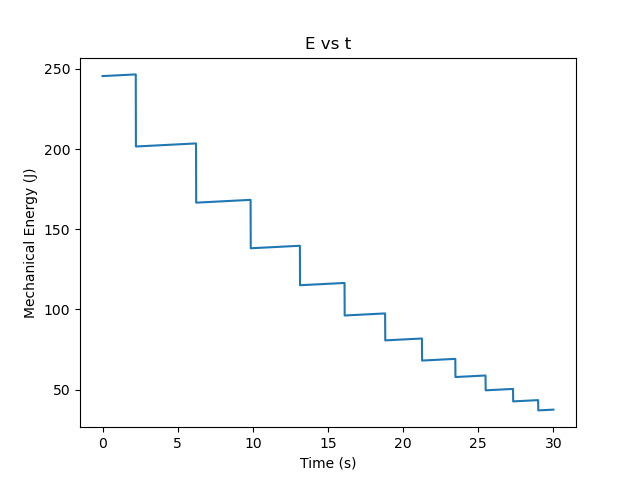

In [24]:
def EnergiaMecanica(t):
    E = []
    for i in range(len(t)):
        v_dot = np.dot(Ptcl.GetVelocityVector()[i],Ptcl.GetVelocityVector()[i])

        K = 0.5*Ptcl.GetMass()*(v_dot)
        
        h = Ptcl.GetPositionVector()[i,1] + Limits[1]
        U = Ptcl.GetMass()*9.8*h
        
        E_i = K + U
        
        E.append(E_i)
    
    return E
EnergiaMecanica(t)

def EMFig(t):
    E = EnergiaMecanica(t)
    
    plt.figure()
    
    plt.plot(t,E)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Mechanical Energy (J)')
    
    plt.title('E vs t')
    
    plt.savefig('Energia.png')
    
    return None

EMFig(t)


In [25]:
Particles = RunSimulationGas(t,NParticles = 100, Velo = 50)

def ReduceTime_2(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

redt_2 = ReduceTime_2(t,10)





100%|██████████████████████████████████████| 3001/3001 [00:05<00:00, 559.74it/s]


<IPython.core.display.Javascript object>


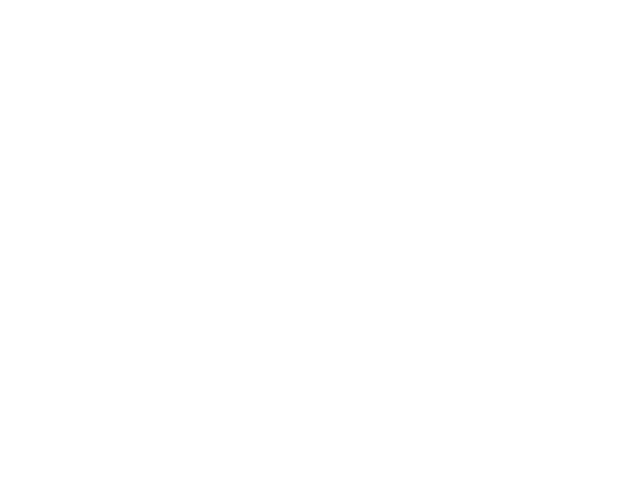

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '50', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'artist=Me', '-y', 'Gas.mp4']' returned non-zero exit status 255.

In [26]:
fig_2 = plt.figure()
ax_2 = fig_2.add_subplot(111, projection='3d')


def init_2():
    ax_2.set_xlim(-Limits_2[0],Limits_2[0])
    ax_2.set_ylim(-Limits_2[1],Limits_2[1])
    ax_2.set_zlim(-Limits_2[2],Limits_2[2])

def Update_2(i):
    
    plot = ax_2.clear()
    init()
    plot = ax_2.set_title(r'$t=%.2f \ seconds$' %(redt_2[i]), fontsize=15)
    
    for p in Particles:
        x = p.GetPositionVector()[i,0]
        y = p.GetPositionVector()[i,1]
        z = p.GetPositionVector()[i,2]
        
        #vx = p.GetVelocityVector()[i,0]
        #vy = p.GetVelocityVector()[i,1]
        #vz = p.GetVelocityVector()[i,2]
        
        ax_2.scatter(x, y, z, zdir='z', s=p.GetR()**0.5)
        
        #plot = ax_2.arrow(x,y,vx,vy,color='r',head_width=0.5)
        
    return plot

Animation_2 = anim.FuncAnimation(fig_2,Update_2,frames=len(redt_2),init_func=init_2)

Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=50, metadata=dict(artist='Me'))
Animation_2.save('Gas.mp4', writer=writer_)

In [38]:
pip install ffmpeg

  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=f0a61bd2f1bce6d0e8d2d5f9dc35c324ce1ee1f3a7d77c6594047cfd541786e5
  Stored in directory: /Users/samuel/Library/Caches/pip/wheels/30/33/46/5ab7eca55b9490dddbf3441c68a29535996270ef1ce8b9b6d7
Successfully built ffmpeg
Note: you may need to restart the kernel to use updated packages.
